# Machine Learning

*Екатерина Лобачева / Илья Щуров / Сергей Сметанин *

*Совместный бакалавриат НИУ ВШЭ и РЭШ, 2016-17 учебный год*

[Страница курса](http://math-info.hse.ru/2016-17/Machine_Learning)

## Домашнее задание №ML2

Чтобы выполнить работу, скачайте настоящий ipynb-файл, откройте его в *Jupyter Notebook*, впишите решения в оставленные для этого ячейки (при необходимости можно добавлять новые ячейки), приводя полный работающий код, а также все необходимые пояснения и ответы (для этого нужно использовать markdown-ячейки). Вы можете вставлять формулы с помощью TeX-разметки в markdown-ячейки. После выполнения работы необходимо вытащить ipynb-файл из Jupyter (например, с помощью *File → Download as… → IPython Notebook*) и загрузить его на my.NES.

### Задача 1
Рассмотрим линейную регрессию с матрицей признаков $X=(x_i^j)$, $i$ — номер столбца (номер признака), $i=1,\ldots, m$, $j$ — номер строки (номер наблюдения или объекта), $j=1,\ldots, n$ и вектором ответов $y=(y^1, \ldots, y^n)$. Запишем квадратичную функцию потерь с $L_2$-регуляризацией:

$$Q(w) = \|Xw - y \|^2 + \alpha \|w\|,$$
где $w$ — вектор весов, $\|a\| = \sqrt{a_1^2 + \ldots + a_m^2}$ — стандартная $L_2$-норма вектора, $\alpha$ — некоторая константа.


1. Найти градиент $\frac{\partial Q(w)}{\partial w}$. Записать его в матричном виде.
2. Реализовать алгоритм градиентного спуска для данной функции потерь. Написать функцию `GD(X, y, max_epoch=1000, eta=0.001, alpha=0.0, tol=0.0001)` со следующими свойствами:
    - Функция вычисляет оптимальный вектор весов $w$ с помощью градиентного спуска.
    - Начальное значение вектора весов: нулевой вектор.
    - Процесс оптимизации останавливается, если сделано `max_epoch * n` шагов (одна эпоха соответствует количеству шагов, равному общему числу наблюдений $n$), либо если значение функции потерь на очередном шаге изменилось менее, чем на `tol`.
    - Коэффициент перед градиентом равен `eta/n`. (Это нужно, чтобы средний шаг был таким же, как в стохастическом градиентном спуске, см. задачу 2.)
    - `alpha` — коэффициент перед регуляризатором.
    - Функция возвращает пару `(w, L)`, где `w` — вектор весов на последнем шаге, `L` — список, состоящий из значений функции потерь в начале каждой эпохи.
    
В качестве источника вдохновения ниже приводится функция `GD_nonreg`, решающая аналогичную задачу без регуляризатора. Вы можете модифицировать её в соответствии с условиями задачи.

In [67]:
def GD_nonreg(X, y, max_epoch=100, eta=0.01, alpha=0.0, tol=0.0001):
    
    # Используя X и y, определим функцию потерь и её градиент:
    def Q(w):
        S = X @ w - y
        return S.T @ S 
    
    def DQ(w):
        return 2.0 * (X.T @ X @ w - X.T @ y)
    
    n, m = X.shape
    # n — число строк в матрице X (число наблюдений), 
    # m — число столбцов (число признаков)
    
    w_prev = np.array([0] * m)
    L = [Q(w_prev)]
    
    for epoch in range(max_epoch):
        w_next = w_prev - eta * DQ(w_prev)
        if abs(Q(w_next) - Q(w_prev)) < tol:
            return w_next, L
        w_prev = w_next
        L.append(Q(w_next))
    return w_next, L

In [124]:
def GD(X, y, max_epoch=10000, eta=0.00001, alpha=0.0, tol=0.0001):
    import numpy as np
    n, m = X.shape
    def Q(w):
        S = X @ w - y
        return S.T @ S + np.sqrt(w @ w) * alpha
    def DQ(w):
        if w @ w == 0:
            return 2 * (X.T @ X @ w - X.T @ y) 
        else:
            return 2 * (X.T @ X @ w - X.T @ y) + alpha * w /np.sqrt(w @ w)
    w_prev = np.array([1] * m)
    L = [Q(w_prev)]
    
    for epoch in range(max_epoch):
        for j in range(n):
            w_next = w_prev - (eta/n) * DQ(w_prev)
            if abs(Q(w_next) - Q(w_prev)) < tol:
                return w_next, L
            w_prev = w_next
        L.append(Q(w_next))
    return w_next, L
    

### Задача 2
Запишем функцию потерь из предыдущей задачи в виде:

$$Q(w) = \sum_{j=1}^n Q_j(w),$$
где $Q_j(w)$ — ошибка на $j$-м наблюдении:

$$Q_j(w) = ( \langle x^j, w\rangle - y^j)^2 + \frac{\alpha}{n} \|w\|^2.$$
Здесь угловыми скобками обозначается стандартное скалярное произведение.

Реализовать алгоритм *стохастического градиентного спуска* для этой функции потерь. Его идея состоит в том, чтобы вместо градиента функции $Q(w)$ на каждом шаге использовать градиент функции $Q_j(w)$ для некоторого наблюдения $j$, выбираемого случайным образом. На практике делают так. Сначала перемешивают наблюдения (выбирают на них случайный порядок). На первых $n$ шагах алгоритма  для вычисления $Q_j$ последовательно перебирают все наблюдения (в соответствии с выбранным случайным порядком). Этот промежуток называется *первой эпохой*. Затем снова перемешивают все наблюдения (выбирают новый случайный порядок — наступает *вторая эпоха*) и на следующих $n$ шагах снова последовательно перебирают все наблюдения (в соответствии с новым случайным порядком). И так далее. 

Более формально:

Выберем случайную перестановку на множестве номеров наблюдений, то есть взаимно однозначную функцию $\pi_1\colon \{1, \ldots, n\} \to \{1, \ldots, n\}$. (Иными словами, перенумеруем наблюдения случайным образом.) На первых $n$ шагах алгоритма будем вместо градиента функции $Q(w)$ использовать градиент функции $Q_{\pi_1(j)}(w)$, где $j=1,\ldots, n$ — номер шага. Затем выберем другую случайную перестановку $\pi_2$ и на следующих $n$ шагах алгоритма будем использовать градиент функции $Q_{\pi_2(j)}$, где $j$ — номер шага от начала второй эпохи. И так далее.

Написать функцию `SGD(X, y, max_epoch=1000, eta=0.001, alpha=0.0, decrease_eta=True)` со следующими свойствами:

- Функция вычисляет оптимальный вектор весов $w$ с помощью стохастического градиентного спуска.
- Начальное значение вектора весов: нулевой вектор.
- Процесс оптимизации останавливается, если прошло `max_epoch` эпох.
- Коэффициент перед градиентом равен `eta`, если `decrease_eta==False`, и равен `eta/epoch_number` в противном случае, где `epoch_number` — номер эпохи.
- `alpha` — коэффициент перед регуляризатором.
- Функция возвращает пару `(w, L)`, где `w` — вектор весов на последнем шаге, `L` — список, состоящий из значений функции потерь в начале каждой эпохи.
    
**Подсказка:** Вы можете использовать функцию `shuffle` из модуля `random` или [sklearn.utils.shuffle](http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) чтобы выбирать случайный порядок наблюдений.

In [136]:
def SGD(X, y, max_epoch=10000, eta=0.00001, alpha=0.0, decrease_eta=True, tol =0.0001):
    import random, numpy as np 
    n, m = X.shape   
    def Q(w):
        S = X @ w - y
        return S.T @ S + w @ w * alpha
    def Qi(w, i):
        x_i = X[i, :]
        y_i = y[i]
        return (x_i @ w - y_i) ** 2  + (w @ w) * alpha / n
    def DQ(w,i):
        x_i = X[i, :]
        return 2 *(x_i @ w * w - x_i * y[i]) + 2 * w * alpha / n

    stoch = np.array(range(n))

    w_prev = np.array([0] * m)
    L = [Q(w_prev)]
    for epoch in range(max_epoch):
        random.shuffle(stoch)
        for j in stoch:
            if decrease_eta == True:
                w_next = w_prev - (eta / (epoch+1)) * DQ(w_prev, j)
            else:
                w_next = w_prev - eta * DQ(w_prev, j)
            if abs(Q(w_next) - Q(w_prev)) < tol:
                return w_next, L
            w_prev = w_next
        L.append(Q(w_next))
    return w_next, L
    

### Задача 3

Сгенерируем данные следующим образом:

In [9]:
from numpy.random import normal, seed
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

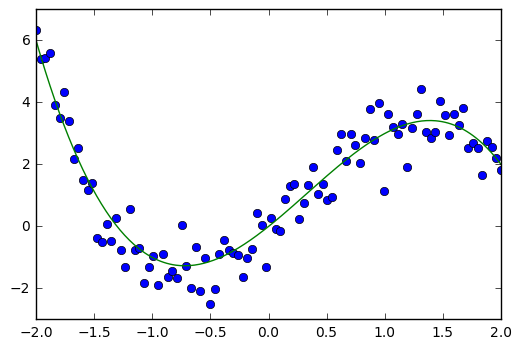

In [13]:
seed(42)
# стартовое состояние генератора случайных чисел: для воспроизводимости

n = 100
# число наблюдений

x_train = np.linspace(-2, 2, n)
y_train = 3 * x_train + x_train**2 - x_train**3 + normal(scale=0.7, size=n, )
x_test = np.linspace(-2, 2, 300)
y_test = 3 * x_test + x_test**2 - x_test**3
# обычно в качестве тестовой выборки используется какая-то часть данных,
# не попавшая в обучающую выборку, но в данном случае мы знаем
# настоящий ответ и будем использовать его для тестирования

plt.plot(x_train, y_train, 'o')
plt.plot(x_test, y_test)

Рассмотрим линейную регрессию
$$y = \beta_1 x + \beta_2 x^2 + \ldots + \beta_d x^d.$$

1. Применить функции `GD` и `SGD` к решению этой регрессионной задачи для $d=10$, $\alpha=0.1$.
2. Построить графики предсказанных значений $y$ от $x$ на тестовой выборке для обеих функций.
3. Нарисовать график зависимости значения функции потерь от номера эпохи для каждой из этих двух функций. Использовать список `L`, возвращаемый кажодй из этих функций. Для `SGD` использовать параметр `decrease_eta=False`, на картинке отразить только те эпохи, до которых доходит `GD`.
4. Какой из методов быстрее работает? С помощью `%%timeit` сравните время выполнения `GD` и `SGD`. Функции `SGD` в качестве `max_epoch` передайте длину списка `L`, возвращённого `GD` (чтобы обе функции работали одинаковое число эпох).

**Примечание.** Вам понадобится сгенерировать матрицы `X_train` и `X_test` с $d$ столбцами, соответствующими степеням $x$. Чтобы регуляризация нормально работала, данные следует нормализовать: разделите каждый столбец на его стандартное отклонение (его можно вычислить с помощью `np.std`). Обычно также вычитают среднее, но мы не будем сейчас этого делать: подобная операция приведёт к появлению константного слагаемого в модели, чего мы сейчас не хотим.

In [126]:
import math
d = 10
n = 100
alpha = 0.1
X_train  = np.array([[0.0] * d] * n )

for i in range(n):
    for j in range(d):
        X_train[i][j] = math.pow(x_train[ i ], j+1)

In [137]:
SGD(X=X_train, y=y_train, alpha=0.1)

(array([  3.84717346e-03,   1.60893763e-02,   9.58493485e-04,
          4.76679733e-02,  -1.09443826e-02,   1.52821538e-01,
         -6.24216012e-02,   5.13225188e-01,  -2.71469594e-01,
          1.77766773e+00]),
 [598.11253209336314,
  3342185.0041472227,
  6731475.5258339038,
  9108977.2359342184,
  10839092.346449807,
  12144550.741351068,
  13168963.385739833,
  14002106.612918383,
  14695899.598933427,
  15271369.001970178,
  15769380.310140919,
  16196540.685664149,
  16569539.706338434,
  16902972.08005948,
  17198394.855649117,
  17463752.337045964,
  17701531.016921382,
  17917818.821982462,
  18114745.426712673,
  18297152.048390504,
  18463793.815304473,
  18617129.479704674,
  18759683.346281294,
  18892015.928230267,
  19014648.536731832,
  19128760.614002023,
  19238003.985165294,
  19338471.102823194,
  19433370.717377737,
  19523542.058944851,
  19608721.848966662,
  19688942.095363032,
  19765026.359908953,
  19837256.083885845,
  19905521.581449583,
  19971107.522011

In [125]:

#print(X_train)
GD(X=X_train, y=y_train, alpha=0.1)
#print(X_train, y_train)
#z=X_train.T @ X_train @ (np.array([1] * 10 )) - X_train.T @ y_train
#z

(array([ 1.20425482,  0.5603534 ,  0.75514732,  0.32507866,  0.22397485,
         0.05605792, -0.42778302, -0.07962299,  0.07303085,  0.01340368]),
 [14476020.21263515,
  12548.132171573367,
  10088.684191195864,
  8172.3480016010863,
  6672.6020586198438,
  5493.0822220165546,
  4560.3262331952683,
  3818.2702591742832,
  3224.0737963536349,
  2744.9517521979087,
  2355.7702340069432,
  2037.2214774970344,
  1774.4379962128394,
  1555.9398761879791,
  1372.8347939528219,
  1218.2097821240291,
  1086.668507791499,
  973.97900348493022,
  876.80526176958972,
  792.50252669532676,
  718.96098426830952,
  654.4862456802,
  597.70781609735911,
  547.50886431827826,
  502.97221822649641,
  463.33873176391887,
  427.97509516779718,
  396.34886273900088,
  368.00900547627629,
  342.57070048333992,
  319.70337618530226,
  299.12126561875567,
  280.575897232697,
  263.85008728608437,
  248.7531003113321,
  235.1167220104843,
  222.79204826112624,
  211.6468391060838,
  201.56332107779136,
  192

### Задача 4

Теперь мы будем использовать регрессионные модели из модуля `sklearn` (scikit-learn). Обучим три модели на основе данных из предыдущей задачи.

1. Без регуляризации: с помощью `LinearRegression()`.
2. С $L_2$-регуляризацией: с помощью `Ridge()`.
3. С $L_1$-регуляризацией: с помощью `Lasso()`.

Пример применения этих функций можно найти [в конспектах Евгения Соколова](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/seminars/sem02-linregr.ipynb).

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

1. Для $d$ равных 1, 2, 3, 5, 10, 30 обучить каждую из трёх указанных выше линейных моделей.
2. Для каждой из моделей построить графики предсказанных значений $y$, вычисленных по тестовым значениям $x$ (элементы `x_test`), и истинных значений $y$. Попробуйте использовать разные значения параметра $\alpha$ для моделей с регуляризацией и посмотрите на эффект.
3. Найти среднеквадратичную ошибку (средний квадрат разности между предсказанными и истинными значениями $y$) для тестовой выборки (для вычисления используйте функцию `mean_squared_error`, импортированную выше). 
4. Какая из моделей сильнее переобучается? 
5. Какой из способов регуляризации позволяет лучше справиться с переобучением? 
6. Для $d=30$ попробуйте подобрать оптимальное значение $\alpha$ для каждого из методов с регуляризацией.
7. Убедитесь, что `Lasso` зануляет некоторые коэффициенты регрессии. (Для вывода списка коэффициентов можно использовать `model.coef_`, где `model` — наша модель.)
7. Какой из методов работает быстрее? (Используйте магическую команду `%%timeit`, чтобы определить время выполнения ячейки.) Как изменится соотношение времени работы, если число наблюдений $n$ увеличить в 10 раз? В 100 раз? (Примечание: `LinearRegression` использует явную формулу для вычисления коэффициентов линейной регрессии, через обращение матрицы. `Ridge` и `Lasso` могут использовать итеративные формулы — градиентный спуск и другие.)

In [149]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print ('R2:', lr.score(X_train,y_train))

lr = Ridge(alpha=0.1, solver='sparse_cg')
lr.fit(X_train,y_train)
print ('R2:', lr.score(X_train,y_train))

lr = Lasso()
lr.fit(X_train,y_train)
print ('R2:', lr.score(X_train,y_train))

R2: 0.917114560984
R2: 0.86087848081
R2: 0.460034300244


C:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
